In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = pd.read_excel('/content/drive/MyDrive/capstone_minatku/preprocessed_RIASEC_3Class.xlsx', engine = 'openpyxl')
dataset.head(n = 10)

,Unnamed: 0,R1,R2,R3,R4,R5,R6,R7,R8,I1,...,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10,major
0,1,1,1,2,4,1,2,2,1,5,...,5,7,4,7,6,6,4,6,1,science
1,5,3,5,1,3,1,5,3,4,4,...,2,3,5,3,6,7,5,2,1,arts and literature
2,6,1,4,1,4,1,4,1,2,4,...,2,5,5,3,6,2,4,7,2,science
3,10,1,1,4,2,1,1,1,1,3,...,5,7,1,7,5,5,1,7,2,economics
4,12,5,3,3,3,3,3,3,3,5,...,3,7,5,7,1,7,1,6,1,social
5,15,4,5,4,5,5,5,5,3,3,...,2,5,6,7,4,5,3,5,3,technology
6,17,4,2,2,4,2,4,4,3,5,...,6,7,6,5,5,6,2,1,1,arts and literature
7,21,3,1,1,1,1,1,2,1,3,...,5,7,7,6,6,7,6,4,1,economics
8,25,1,1,1,1,1,1,1,1,2,...,6,5,5,7,5,5,6,2,2,arts and literature
9,27,3,1,1,1,1,1,1,1,3,...,5,3,7,7,7,5,5,1,1,arts and literature


In [5]:
# dataset.drop(columns = ['Unnamed: 0']) # Uncomment this line if filename == 'preprocessed_RIASEC_Class3.xlsx'
data_cols = list(dataset.columns)
data_cols.remove('major')
data = dataset[data_cols].values
labels = dataset['major'].values

In [6]:
labels = labels.reshape((1, labels.shape[0]))
transformer = ColumnTransformer([('one_hot_encoder', OneHotEncoder(sparse = False), [0])],
                                remainder = 'passthrough')
labels = transformer.fit_transform(labels.T)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [26]:
def create_model(input_shape, learning_rate = 1e-5, dropout_rate = 0.5, optimizer = None):
    """
    Create a three layers DNN model with 2 dropout layers for regularization.

    Keyword Argument:
    input_shape -- a tuple defining the input_shape of the first layer. The value equals to the number of
                   features used.
    learning_rate -- defines the learning rate to be used for the default Adam optimizer. Default
                     value is 1e-4.
    dropout_rate -- defines the percentage of total weights to be dropped. Default value is 0.2,
                    meaning 20% of total weights are zeroed.
    optimizer -- if None, Adam will be used as default optimizer. Pass a tf.keras.optimizers method
                 to use another optimizer.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units = 256, input_shape = input_shape, activation = 'relu'),
        tf.keras.layers.Dense(units = 128, activation = 'relu'),
        tf.keras.layers.Dense(units = 64, activation = 'relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(units = 32, activation = 'relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(units = 5, activation = 'softmax')
    ])
    if not optimizer:
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
                      loss = 'categorical_crossentropy', metrics = ['accuracy'])
    else:
        model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [27]:
def predict_assess(model, validation_data, validation_label):
    """
    Make predictions based on an array of data and assess the prediction using
    accuracy, precision, and recall.

    Keyword Argument:
    model -- the model for making predictions.

    validation_data -- an array of data for making predictions.

    validation_label -- an array of labels of the data in validation_data.
    """
    predictions = model.predict(validation_data)
    predictions = np.array([np.argmax(prediction) for prediction in predictions])
    actuals = np.array([np.argmax(actual) for actual in validation_label])
    accuracy = accuracy_score(predictions, actuals)
    precision = precision_score(predictions, actuals, average = 'weighted')
    recall = recall_score(predictions, actuals, average = 'weighted')
    return accuracy, precision, recall

In [28]:
def training_report(accuracy, precision, recall, num_features = None):
    """
    Print a training report based on model's performance.

    Keyword Argument:
    accuracy -- the accuracy score of the model.

    precision -- precision score.

    recall -- recall score.

    num_features -- a scalar value defining the number of features used during training.
                    If None, all features are assumed to be in use.
    """
    if not num_features:
        print('Accuracy, Precision, and Recall for all features')
    else:
        print('Accuracy, Precision, and Recall for {} features'.format(num_features))
    print('Accuracy: {}'.format(acc))
    print('Precision: {}'.format(prec))
    print('Recall: {}'.format(rec))

In [29]:
training_history = {'num_features': [], 'acc': [], 'prec': [], 'rec': []}
def add_to_history(hist_dict, n_features, acc, prec, rec):
    """
    Add model's performance result to hist_dict dictionary containing 'num_features',
    'acc', 'prec', and 'rec' keys. The value of all keys are in lists.

    Keyword Argument:
    hist_dict -- the dictionary where training performance will be saved. Must contain
                 'num_features', 'acc', 'prec', and 'rec' keys in which all of them must be
                 lists.

    n_features -- number of features used during training. The value will be added to
                  'num_features'.

    acc -- the obtained accuracy of a model.

    prec -- precision score of a model.

    rec -- recall score.
    """
    hist_dict['num_features'].append(n_features)
    hist_dict['acc'].append(acc)
    hist_dict['prec'].append(prec)
    hist_dict['rec'].append(rec)

In [30]:
data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size = 0.25)

In [32]:
model = create_model(input_shape = (len(dataset.columns) - 1, ),
                     optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-3))
history = model.fit(data_train, label_train, batch_size = 32, epochs = 280, validation_data = (data_test, label_test))
acc, prec, rec = predict_assess(model, data_test, label_test)
training_report(acc, prec, rec)

Epoch 1/280
61/61 [==============================] - 1s 10ms/step - loss: 106.5157 - accuracy: 0.2213 - val_loss: 1.6095 - val_accuracy: 0.2181
Epoch 2/280
61/61 [==============================] - 0s 5ms/step - loss: 1.6132 - accuracy: 0.2433 - val_loss: 1.6088 - val_accuracy: 0.2181
Epoch 3/280
61/61 [==============================] - 0s 6ms/step - loss: 1.6080 - accuracy: 0.2433 - val_loss: 1.6080 - val_accuracy: 0.2258
Epoch 4/280
61/61 [==============================] - 0s 7ms/step - loss: 1.6093 - accuracy: 0.2454 - val_loss: 1.6075 - val_accuracy: 0.2258
Epoch 5/280
61/61 [==============================] - 0s 5ms/step - loss: 1.6133 - accuracy: 0.2439 - val_loss: 1.6074 - val_accuracy: 0.2304
Epoch 6/280
61/61 [==============================] - 0s 5ms/step - loss: 1.6108 - accuracy: 0.2454 - val_loss: 1.6065 - val_accuracy: 0.2289
Epoch 7/280
61/61 [==============================] - 0s 5ms/step - loss: 1.6049 - accuracy: 0.2449 - val_loss: 1.6065 - val_accuracy: 0.2289
Epoch 8/28

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
k_fold = KFold(n_splits = 5)
for train_index, test_index in k_fold.split(data):
    data_train, data_test = data[train_index], data[test_index]
    label_train, label_test = labels[train_index], labels[test_index]
    model = create_model(input_shape = (len(dataset.columns) - 1, ))
    history = model.fit(data_train, label_train, batch_size = 32, epochs = 50)
    acc, prec, rec = predict_assess(model, data_test, label_test)
    training_report(acc, prec, rec)
    add_to_history(training_history, len(dataset.columns), acc, prec, rec)

Epoch 1/50
66/66 [==============================] - 2s 3ms/step - loss: 443.2243 - accuracy: 0.1979
Epoch 2/50
66/66 [==============================] - 0s 3ms/step - loss: 360.7437 - accuracy: 0.1787
Epoch 3/50
66/66 [==============================] - 0s 3ms/step - loss: 309.7514 - accuracy: 0.1878
Epoch 4/50
66/66 [==============================] - 0s 3ms/step - loss: 254.7833 - accuracy: 0.1825
Epoch 5/50
66/66 [==============================] - 0s 3ms/step - loss: 222.7438 - accuracy: 0.1940
Epoch 6/50
66/66 [==============================] - 0s 3ms/step - loss: 191.8794 - accuracy: 0.1940
Epoch 7/50
66/66 [==============================] - 0s 3ms/step - loss: 165.4092 - accuracy: 0.1854
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 139.5085 - accuracy: 0.1931
Epoch 9/50
66/66 [==============================] - 0s 3ms/step - loss: 130.3552 - accuracy: 0.1844
Epoch 10/50
66/66 [==============================] - 0s 3ms/step - loss: 107.9572 - accuracy: 0.2037

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


66/66 [==============================] - 2s 5ms/step - loss: 307.8507 - accuracy: 0.1897
Epoch 2/50
66/66 [==============================] - 0s 5ms/step - loss: 249.2070 - accuracy: 0.1825
Epoch 3/50
66/66 [==============================] - 0s 5ms/step - loss: 195.8452 - accuracy: 0.1945
Epoch 4/50
66/66 [==============================] - 0s 6ms/step - loss: 166.6598 - accuracy: 0.1897
Epoch 5/50
66/66 [==============================] - 1s 18ms/step - loss: 136.4223 - accuracy: 0.2037
Epoch 6/50
66/66 [==============================] - 0s 5ms/step - loss: 124.0111 - accuracy: 0.1974
Epoch 7/50
66/66 [==============================] - 0s 3ms/step - loss: 104.6644 - accuracy: 0.2041
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 89.7230 - accuracy: 0.2017
Epoch 9/50
66/66 [==============================] - 0s 3ms/step - loss: 80.7325 - accuracy: 0.1916
Epoch 10/50
66/66 [==============================] - 0s 3ms/step - loss: 70.4274 - accuracy: 0.1820
Epoch 11/50


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


66/66 [==============================] - 2s 4ms/step - loss: 453.8232 - accuracy: 0.2017
Epoch 2/50
66/66 [==============================] - 0s 5ms/step - loss: 410.4395 - accuracy: 0.2017
Epoch 3/50
66/66 [==============================] - 0s 5ms/step - loss: 353.2269 - accuracy: 0.1988
Epoch 4/50
66/66 [==============================] - 0s 5ms/step - loss: 302.5330 - accuracy: 0.2041
Epoch 5/50
66/66 [==============================] - 0s 4ms/step - loss: 276.0893 - accuracy: 0.1955
Epoch 6/50
66/66 [==============================] - 0s 4ms/step - loss: 239.5616 - accuracy: 0.1916
Epoch 7/50
66/66 [==============================] - 0s 5ms/step - loss: 208.7741 - accuracy: 0.1792
Epoch 8/50
66/66 [==============================] - 0s 5ms/step - loss: 170.2783 - accuracy: 0.2041
Epoch 9/50
66/66 [==============================] - 0s 5ms/step - loss: 153.9999 - accuracy: 0.1888
Epoch 10/50
66/66 [==============================] - 0s 5ms/step - loss: 119.6742 - accuracy: 0.2008
Epoch 11/5

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


66/66 [==============================] - 2s 3ms/step - loss: 354.8930 - accuracy: 0.2141
Epoch 2/50
66/66 [==============================] - 0s 3ms/step - loss: 304.8152 - accuracy: 0.1992
Epoch 3/50
66/66 [==============================] - 0s 3ms/step - loss: 255.9797 - accuracy: 0.2036
Epoch 4/50
66/66 [==============================] - 0s 3ms/step - loss: 218.4130 - accuracy: 0.2136
Epoch 5/50
66/66 [==============================] - 0s 3ms/step - loss: 190.1098 - accuracy: 0.2127
Epoch 6/50
66/66 [==============================] - 0s 3ms/step - loss: 167.3119 - accuracy: 0.2055
Epoch 7/50
66/66 [==============================] - 0s 3ms/step - loss: 149.0147 - accuracy: 0.1863
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 121.3899 - accuracy: 0.2127
Epoch 9/50
66/66 [==============================] - 0s 3ms/step - loss: 109.7922 - accuracy: 0.2021
Epoch 10/50
66/66 [==============================] - 0s 3ms/step - loss: 93.8682 - accuracy: 0.2199
Epoch 11/50

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


66/66 [==============================] - 2s 5ms/step - loss: 302.3443 - accuracy: 0.1757
Epoch 2/50
66/66 [==============================] - 0s 5ms/step - loss: 250.5031 - accuracy: 0.1882
Epoch 3/50
66/66 [==============================] - 0s 4ms/step - loss: 197.9112 - accuracy: 0.1925
Epoch 4/50
66/66 [==============================] - 0s 3ms/step - loss: 172.3871 - accuracy: 0.1819
Epoch 5/50
66/66 [==============================] - 0s 3ms/step - loss: 148.2324 - accuracy: 0.1940
Epoch 6/50
66/66 [==============================] - 0s 3ms/step - loss: 129.5315 - accuracy: 0.1877
Epoch 7/50
66/66 [==============================] - 0s 3ms/step - loss: 104.4066 - accuracy: 0.2074
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 93.0077 - accuracy: 0.1978
Epoch 9/50
66/66 [==============================] - 0s 3ms/step - loss: 83.3355 - accuracy: 0.1973
Epoch 10/50
66/66 [==============================] - 0s 3ms/step - loss: 73.4644 - accuracy: 0.1930
Epoch 11/50
6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
classifier = RandomForestClassifier(n_estimators = 1500, random_state = 42, n_jobs = -1)
classifier.fit(data_train, label_train)
feat_labels = dataset.columns[:-1]
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]

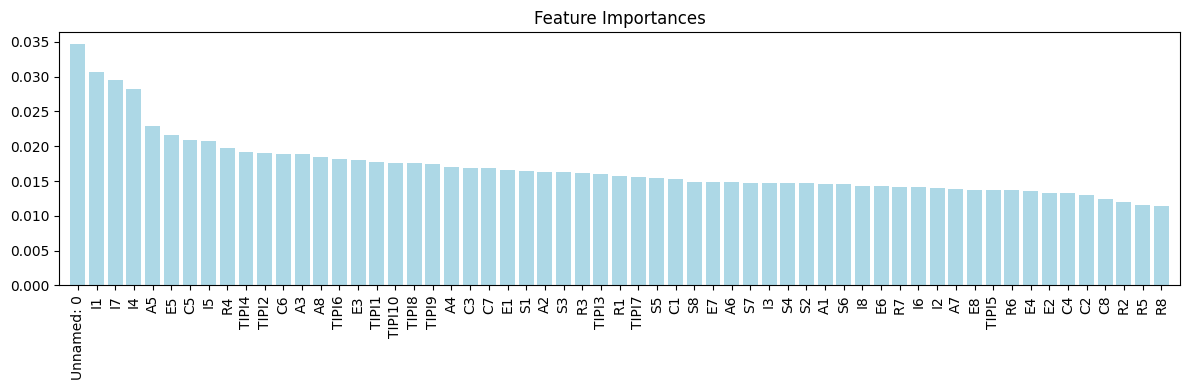

In [35]:
plt.figure(figsize = (12, 4))
plt.title('Feature Importances')
plt.bar(range(data_train.shape[1]), importances[indices], color='lightblue', align='center')
plt.xticks(range(data_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, data_train.shape[1]])
plt.tight_layout()
plt.show()

In [36]:
threshold = 40
total_features = len(feat_labels) - 1
for num_features in range(total_features, threshold, -1):
    new_dataset = dataset.drop(columns = feat_labels[indices[num_features:]])
    new_data = new_dataset[feat_labels[indices[:num_features]]].values
    new_labels = new_dataset['major'].values
    new_labels = new_labels.reshape((1, new_labels.shape[0]))
    new_labels = transformer.fit_transform(new_labels.T)
    for train_index, test_index in k_fold.split(new_data):
        data_train, data_test = new_data[train_index], new_data[test_index]
        label_train, label_test = labels[train_index], labels[test_index]
        model = create_model(input_shape = (num_features, ))
        history = model.fit(data_train, label_train, epochs = 50, batch_size = 32)
        acc, prec, rec = predict_assess(model, data_test, label_test)
        training_report(acc, prec, rec, threshold)
        add_to_history(training_history, threshold, acc, prec, rec)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


66/66 [==============================] - 1s 3ms/step - loss: 409.8941 - accuracy: 0.1945
Epoch 2/50
66/66 [==============================] - 0s 3ms/step - loss: 326.0158 - accuracy: 0.1955
Epoch 3/50
66/66 [==============================] - 0s 3ms/step - loss: 275.4792 - accuracy: 0.1955
Epoch 4/50
66/66 [==============================] - 0s 3ms/step - loss: 227.3491 - accuracy: 0.2190
Epoch 5/50
66/66 [==============================] - 0s 3ms/step - loss: 194.8692 - accuracy: 0.2041
Epoch 6/50
66/66 [==============================] - 0s 3ms/step - loss: 163.1930 - accuracy: 0.1979
Epoch 7/50
66/66 [==============================] - 0s 3ms/step - loss: 129.9244 - accuracy: 0.2152
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 108.4335 - accuracy: 0.2181
Epoch 9/50
66/66 [==============================] - 0s 3ms/step - loss: 89.0808 - accuracy: 0.2027
Epoch 10/50
66/66 [==============================] - 0s 3ms/step - loss: 73.5573 - accuracy: 0.1926
Epoch 11/50


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


66/66 [==============================] - 1s 3ms/step - loss: 488.5096 - accuracy: 0.1825
Epoch 2/50
66/66 [==============================] - 0s 3ms/step - loss: 393.1729 - accuracy: 0.1940
Epoch 3/50
66/66 [==============================] - 0s 3ms/step - loss: 321.4138 - accuracy: 0.1955
Epoch 4/50
66/66 [==============================] - 0s 3ms/step - loss: 295.4818 - accuracy: 0.1806
Epoch 5/50
66/66 [==============================] - 0s 3ms/step - loss: 247.0709 - accuracy: 0.1883
Epoch 6/50
66/66 [==============================] - 0s 3ms/step - loss: 208.4434 - accuracy: 0.1907
Epoch 7/50
66/66 [==============================] - 0s 3ms/step - loss: 180.7810 - accuracy: 0.1873
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 160.0503 - accuracy: 0.1955
Epoch 9/50
66/66 [==============================] - 0s 3ms/step - loss: 143.0484 - accuracy: 0.2012
Epoch 10/50
66/66 [==============================] - 0s 3ms/step - loss: 117.4871 - accuracy: 0.1955
Epoch 11/5

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


66/66 [==============================] - 1s 3ms/step - loss: 174.9313 - accuracy: 0.1781
Epoch 2/50
66/66 [==============================] - 0s 3ms/step - loss: 141.7635 - accuracy: 0.2040
Epoch 3/50
66/66 [==============================] - 0s 3ms/step - loss: 113.7557 - accuracy: 0.1978
Epoch 4/50
66/66 [==============================] - 0s 3ms/step - loss: 97.8885 - accuracy: 0.2036
Epoch 5/50
66/66 [==============================] - 0s 3ms/step - loss: 85.7219 - accuracy: 0.1863
Epoch 6/50
66/66 [==============================] - 0s 3ms/step - loss: 69.2018 - accuracy: 0.2040
Epoch 7/50
66/66 [==============================] - 0s 3ms/step - loss: 59.1687 - accuracy: 0.1988
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 51.5595 - accuracy: 0.1944
Epoch 9/50
66/66 [==============================] - 0s 3ms/step - loss: 43.5546 - accuracy: 0.2132
Epoch 10/50
66/66 [==============================] - 0s 3ms/step - loss: 35.8751 - accuracy: 0.2012
Epoch 11/50
66/66

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


66/66 [==============================] - 2s 3ms/step - loss: 313.3123 - accuracy: 0.2088
Epoch 2/50
66/66 [==============================] - 0s 3ms/step - loss: 263.9339 - accuracy: 0.2040
Epoch 3/50
66/66 [==============================] - 0s 3ms/step - loss: 226.9919 - accuracy: 0.1949
Epoch 4/50
66/66 [==============================] - 0s 3ms/step - loss: 188.8447 - accuracy: 0.2016
Epoch 5/50
66/66 [==============================] - 0s 3ms/step - loss: 152.3739 - accuracy: 0.2093
Epoch 6/50
66/66 [==============================] - 0s 3ms/step - loss: 130.7963 - accuracy: 0.1911
Epoch 7/50
66/66 [==============================] - 0s 3ms/step - loss: 118.6064 - accuracy: 0.1983
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 99.8412 - accuracy: 0.2117
Epoch 9/50
66/66 [==============================] - 0s 3ms/step - loss: 89.2181 - accuracy: 0.2103
Epoch 10/50
66/66 [==============================] - 0s 3ms/step - loss: 75.0672 - accuracy: 0.2021
Epoch 11/50
6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/50
66/66 [==============================] - 2s 5ms/step - loss: 832.6610 - accuracy: 0.1873
Epoch 2/50
66/66 [==============================] - 0s 5ms/step - loss: 670.8768 - accuracy: 0.2089
Epoch 3/50
66/66 [==============================] - 0s 4ms/step - loss: 565.7504 - accuracy: 0.1936
Epoch 4/50
66/66 [==============================] - 0s 4ms/step - loss: 482.7301 - accuracy: 0.1950
Epoch 5/50
66/66 [==============================] - 0s 5ms/step - loss: 397.5895 - accuracy: 0.2041
Epoch 6/50
66/66 [==============================] - 0s 5ms/step - loss: 339.5748 - accuracy: 0.1993
Epoch 7/50
66/66 [==============================] - 0s 5ms/step - loss: 293.0008 - accuracy: 0.1988
Epoch 8/50
66/66 [==============================] - 0s 5ms/step - loss: 263.2677 - accuracy: 0.2003
Epoch 9/50
66/66 [==============================] - 0s 5ms/step - loss: 226.1728 - accuracy: 0.1974
Epoch 10/50
66/66 [==============================] - 0s 5ms/step - loss: 197.7027 - accuracy: 0.1988

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


66/66 [==============================] - 2s 3ms/step - loss: 342.5524 - accuracy: 0.2133
Epoch 2/50
66/66 [==============================] - 0s 3ms/step - loss: 276.8878 - accuracy: 0.1840
Epoch 3/50
66/66 [==============================] - 0s 3ms/step - loss: 229.1688 - accuracy: 0.1984
Epoch 4/50
66/66 [==============================] - 0s 3ms/step - loss: 195.0481 - accuracy: 0.2017
Epoch 5/50
66/66 [==============================] - 0s 3ms/step - loss: 168.7654 - accuracy: 0.1878
Epoch 6/50
66/66 [==============================] - 0s 3ms/step - loss: 132.0133 - accuracy: 0.1984
Epoch 7/50
66/66 [==============================] - 0s 3ms/step - loss: 108.9822 - accuracy: 0.2008
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 85.6187 - accuracy: 0.1984
Epoch 9/50
66/66 [==============================] - 0s 3ms/step - loss: 69.9183 - accuracy: 0.2085
Epoch 10/50
66/66 [==============================] - 0s 3ms/step - loss: 62.2250 - accuracy: 0.1921
Epoch 11/50
6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


66/66 [==============================] - 2s 5ms/step - loss: 547.2499 - accuracy: 0.1887
Epoch 2/50
66/66 [==============================] - 0s 4ms/step - loss: 465.3280 - accuracy: 0.1728
Epoch 3/50
66/66 [==============================] - 0s 4ms/step - loss: 422.9086 - accuracy: 0.1800
Epoch 4/50
66/66 [==============================] - 0s 4ms/step - loss: 361.8448 - accuracy: 0.1882
Epoch 5/50
66/66 [==============================] - 0s 5ms/step - loss: 333.8266 - accuracy: 0.1767
Epoch 6/50
66/66 [==============================] - 0s 4ms/step - loss: 276.5334 - accuracy: 0.1896
Epoch 7/50
66/66 [==============================] - 0s 5ms/step - loss: 241.2652 - accuracy: 0.1988
Epoch 8/50
66/66 [==============================] - 0s 5ms/step - loss: 215.6096 - accuracy: 0.1949
Epoch 9/50
66/66 [==============================] - 0s 5ms/step - loss: 185.8691 - accuracy: 0.1997
Epoch 10/50
66/66 [==============================] - 0s 5ms/step - loss: 159.7551 - accuracy: 0.1959
Epoch 11/5

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


66/66 [==============================] - 1s 3ms/step - loss: 277.9557 - accuracy: 0.2021
Epoch 2/50
66/66 [==============================] - 0s 3ms/step - loss: 243.0795 - accuracy: 0.2002
Epoch 3/50
66/66 [==============================] - 0s 3ms/step - loss: 217.9403 - accuracy: 0.1973
Epoch 4/50
66/66 [==============================] - 0s 3ms/step - loss: 180.9145 - accuracy: 0.1983
Epoch 5/50
66/66 [==============================] - 0s 3ms/step - loss: 158.4514 - accuracy: 0.2021
Epoch 6/50
66/66 [==============================] - 0s 3ms/step - loss: 134.7023 - accuracy: 0.1935
Epoch 7/50
66/66 [==============================] - 0s 4ms/step - loss: 113.8982 - accuracy: 0.2084
Epoch 8/50
66/66 [==============================] - 0s 4ms/step - loss: 98.5427 - accuracy: 0.1968
Epoch 9/50
66/66 [==============================] - 0s 4ms/step - loss: 79.1692 - accuracy: 0.2175
Epoch 10/50
66/66 [==============================] - 0s 5ms/step - loss: 65.6665 - accuracy: 0.1920
Epoch 11/50
6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


66/66 [==============================] - 1s 3ms/step - loss: 484.6243 - accuracy: 0.2152
Epoch 2/50
66/66 [==============================] - 0s 3ms/step - loss: 415.2216 - accuracy: 0.1988
Epoch 3/50
66/66 [==============================] - 0s 3ms/step - loss: 358.7729 - accuracy: 0.1998
Epoch 4/50
66/66 [==============================] - 0s 3ms/step - loss: 307.2752 - accuracy: 0.2032
Epoch 5/50
66/66 [==============================] - 0s 3ms/step - loss: 253.8726 - accuracy: 0.1912
Epoch 6/50
66/66 [==============================] - 0s 3ms/step - loss: 221.2459 - accuracy: 0.2262
Epoch 7/50
66/66 [==============================] - 0s 3ms/step - loss: 183.3878 - accuracy: 0.1940
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 160.5002 - accuracy: 0.1940
Epoch 9/50
66/66 [==============================] - 0s 3ms/step - loss: 123.5369 - accuracy: 0.1945
Epoch 10/50
66/66 [==============================] - 0s 3ms/step - loss: 104.6335 - accuracy: 0.1998
Epoch 11/5

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


66/66 [==============================] - 1s 3ms/step - loss: 389.6298 - accuracy: 0.1940
Epoch 2/50
66/66 [==============================] - 0s 3ms/step - loss: 319.3092 - accuracy: 0.1912
Epoch 3/50
66/66 [==============================] - 0s 3ms/step - loss: 258.0523 - accuracy: 0.2142
Epoch 4/50
66/66 [==============================] - 0s 3ms/step - loss: 221.4890 - accuracy: 0.1993
Epoch 5/50
66/66 [==============================] - 0s 3ms/step - loss: 180.8188 - accuracy: 0.2133
Epoch 6/50
66/66 [==============================] - 0s 3ms/step - loss: 158.4350 - accuracy: 0.2137
Epoch 7/50
66/66 [==============================] - 0s 3ms/step - loss: 128.4976 - accuracy: 0.1878
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 102.9247 - accuracy: 0.2041
Epoch 9/50
66/66 [==============================] - 0s 3ms/step - loss: 84.3313 - accuracy: 0.2022
Epoch 10/50
66/66 [==============================] - 0s 3ms/step - loss: 67.4318 - accuracy: 0.1969
Epoch 11/50


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
66/66 [==============================] - 1s 3ms/step - loss: 467.7744 - accuracy: 0.1786
Epoch 2/50
66/66 [==============================] - 0s 3ms/step - loss: 333.6568 - accuracy: 0.1887
Epoch 3/50
66/66 [==============================] - 0s 3ms/step - loss: 251.8676 - accuracy: 0.1863
Epoch 4/50
66/66 [==============================] - 0s 3ms/step - loss: 192.2607 - accuracy: 0.1954
Epoch 5/50
66/66 [==============================] - 0s 3ms/step - loss: 156.3287 - accuracy: 0.2055
Epoch 6/50
66/66 [==============================] - 0s 3ms/step - loss: 141.0116 - accuracy: 0.1949
Epoch 7/50
66/66 [==============================] - 0s 3ms/step - loss: 120.3494 - accuracy: 0.1795
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 108.1991 - accuracy: 0.1762
Epoch 9/50
66/66 [==============================] - 0s 4ms/step - loss: 85.0584 - accuracy: 0.2012
Epoch 10/50
66/66 [==============================] - 0s 3ms/step - loss: 76.8673 - accuracy: 0.1896
E

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
66/66 [==============================] - 2s 5ms/step - loss: 305.3840 - accuracy: 0.2170
Epoch 2/50
66/66 [==============================] - 0s 5ms/step - loss: 279.4778 - accuracy: 0.2204
Epoch 3/50
66/66 [==============================] - 0s 5ms/step - loss: 233.0320 - accuracy: 0.2136
Epoch 4/50
66/66 [==============================] - 0s 5ms/step - loss: 213.3077 - accuracy: 0.2165
Epoch 5/50
66/66 [==============================] - 0s 5ms/step - loss: 183.3271 - accuracy: 0.2204
Epoch 6/50
66/66 [==============================] - 0s 5ms/step - loss: 163.1654 - accuracy: 0.2103
Epoch 7/50
66/66 [==============================] - 0s 4ms/step - loss: 147.4830 - accuracy: 0.2098
Epoch 8/50
66/66 [==============================] - 0s 5ms/step - loss: 128.7060 - accuracy: 0.1973
Epoch 9/50
66/66 [==============================] - 0s 5ms/step - loss: 112.8761 - accuracy: 0.2031
Epoch 10/50
66/66 [==============================] - 0s 5ms/step - loss: 94.3340 - accuracy: 0.2136


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


66/66 [==============================] - 1s 3ms/step - loss: 546.7404 - accuracy: 0.2075
Epoch 2/50
66/66 [==============================] - 0s 3ms/step - loss: 455.3171 - accuracy: 0.2003
Epoch 3/50
66/66 [==============================] - 0s 3ms/step - loss: 370.4981 - accuracy: 0.2012
Epoch 4/50
66/66 [==============================] - 0s 3ms/step - loss: 314.2789 - accuracy: 0.2003
Epoch 5/50
66/66 [==============================] - 0s 3ms/step - loss: 245.9957 - accuracy: 0.1950
Epoch 6/50
66/66 [==============================] - 0s 3ms/step - loss: 202.9942 - accuracy: 0.2190
Epoch 7/50
66/66 [==============================] - 0s 3ms/step - loss: 160.5723 - accuracy: 0.2003
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 123.6027 - accuracy: 0.2037
Epoch 9/50
66/66 [==============================] - 0s 3ms/step - loss: 96.9381 - accuracy: 0.2142
Epoch 10/50
66/66 [==============================] - 0s 3ms/step - loss: 73.3964 - accuracy: 0.2051
Epoch 11/50


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
66/66 [==============================] - 2s 5ms/step - loss: 380.1374 - accuracy: 0.2056
Epoch 2/50
66/66 [==============================] - 0s 5ms/step - loss: 318.3294 - accuracy: 0.2017
Epoch 3/50
66/66 [==============================] - 0s 5ms/step - loss: 266.5396 - accuracy: 0.2003
Epoch 4/50
66/66 [==============================] - 0s 5ms/step - loss: 218.1154 - accuracy: 0.1844
Epoch 5/50
66/66 [==============================] - 0s 5ms/step - loss: 173.6468 - accuracy: 0.2041
Epoch 6/50
66/66 [==============================] - 0s 5ms/step - loss: 142.6206 - accuracy: 0.2056
Epoch 7/50
66/66 [==============================] - 0s 5ms/step - loss: 111.1556 - accuracy: 0.2017
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 89.5744 - accuracy: 0.1945
Epoch 9/50
66/66 [==============================] - 0s 3ms/step - loss: 72.9870 - accuracy: 0.2181
Epoch 10/50
66/66 [==============================] - 0s 3ms/step - loss: 56.3213 - accuracy: 0.2089
Ep

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


66/66 [==============================] - 2s 5ms/step - loss: 434.8769 - accuracy: 0.1992
Epoch 2/50
66/66 [==============================] - 0s 5ms/step - loss: 355.9875 - accuracy: 0.1978
Epoch 3/50
66/66 [==============================] - 0s 5ms/step - loss: 315.1132 - accuracy: 0.1940
Epoch 4/50
66/66 [==============================] - 0s 6ms/step - loss: 265.9748 - accuracy: 0.1829
Epoch 5/50
66/66 [==============================] - 0s 5ms/step - loss: 230.0423 - accuracy: 0.2031
Epoch 6/50
66/66 [==============================] - 0s 5ms/step - loss: 208.8234 - accuracy: 0.1959
Epoch 7/50
66/66 [==============================] - 0s 5ms/step - loss: 176.4281 - accuracy: 0.1930
Epoch 8/50
66/66 [==============================] - 0s 4ms/step - loss: 144.8455 - accuracy: 0.2098
Epoch 9/50
66/66 [==============================] - 0s 7ms/step - loss: 124.4440 - accuracy: 0.1882
Epoch 10/50
66/66 [==============================] - 1s 17ms/step - loss: 100.0718 - accuracy: 0.2002
Epoch 11/

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


66/66 [==============================] - 1s 3ms/step - loss: 230.2980 - accuracy: 0.2007
Epoch 2/50
66/66 [==============================] - 0s 3ms/step - loss: 194.3119 - accuracy: 0.2112
Epoch 3/50
66/66 [==============================] - 0s 3ms/step - loss: 155.2877 - accuracy: 0.2199
Epoch 4/50
66/66 [==============================] - 0s 3ms/step - loss: 121.8150 - accuracy: 0.2146
Epoch 5/50
66/66 [==============================] - 0s 3ms/step - loss: 107.1599 - accuracy: 0.2021
Epoch 6/50
66/66 [==============================] - 0s 3ms/step - loss: 86.2931 - accuracy: 0.2103
Epoch 7/50
66/66 [==============================] - 0s 3ms/step - loss: 70.2816 - accuracy: 0.2127
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 58.3434 - accuracy: 0.2012
Epoch 9/50
66/66 [==============================] - 0s 3ms/step - loss: 48.6954 - accuracy: 0.2016
Epoch 10/50
66/66 [==============================] - 0s 4ms/step - loss: 39.8320 - accuracy: 0.2026
Epoch 11/50
66/

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/50
66/66 [==============================] - 1s 3ms/step - loss: 643.4594 - accuracy: 0.2094
Epoch 2/50
66/66 [==============================] - 0s 4ms/step - loss: 536.2585 - accuracy: 0.1960
Epoch 3/50
66/66 [==============================] - 0s 3ms/step - loss: 432.6747 - accuracy: 0.2051
Epoch 4/50
66/66 [==============================] - 0s 4ms/step - loss: 360.1970 - accuracy: 0.1955
Epoch 5/50
66/66 [==============================] - 0s 4ms/step - loss: 305.8428 - accuracy: 0.2046
Epoch 6/50
66/66 [==============================] - 0s 3ms/step - loss: 259.8650 - accuracy: 0.1782
Epoch 7/50
66/66 [==============================] - 0s 3ms/step - loss: 211.6404 - accuracy: 0.2022
Epoch 8/50
66/66 [==============================] - 0s 3ms/step - loss: 183.1549 - accuracy: 0.1950
Epoch 9/50
66/66 [==============================] - 0s 4ms/step - loss: 145.4745 - accuracy: 0.2267
Epoch 10/50
66/66 [==============================] - 0s 4ms/step - loss: 136.6084 - accuracy: 0.2099

KeyboardInterrupt: ignored

In [ ]:
history_df = pd.DataFrame(training_history)
history_df.to_csv('history.csv')